# Benchmark GSEA speed

Compare speed of GSEApy, fGSEA, and blitzGSEA. The runtime of fGSEA is calculated in a separate notebook as it runs in an R environment.

In [117]:
%%capture
!pip3 install git+https://github.com/MaayanLab/blitzgsea.git

In [3]:
!pip3 install gseapy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.9/447.9 kB 4.9 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import importlib

import sys
sys.path.append('blitzgsea')

import blitzgsea as blitz
importlib.reload(blitz)

import gseapy

import time
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import tqdm

In [1]:
!pip3 install gseapy --upgrade

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import blitzgsea as blitz
import pandas as pd

# read signature as pandas dataframe
signature = pd.read_csv("https://github.com/MaayanLab/blitzgsea/raw/main/testing/ageing_muscle_gtex.tsv")

# list available gene set libraries in Enrichr
blitz.enrichr.print_libraries()

# use enrichr submodule to retrieve gene set library
library = blitz.enrichr.get_library("KEGG_2021_Human")

# run enrichment analysis
result = blitz.gsea(signature, library)

{'LIBRARY_LIST_URL': 'https://maayanlab.cloud/speedrichr/api/listlibs', 'LIBRARY_DOWNLOAD_URL': 'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName='}
0 - GeneSigDB
1 - Enrichr_Submissions_TF-Gene_Coocurrence
2 - SysMyo_Muscle_Gene_Sets
3 - WikiPathway_2021_Human
4 - HomoloGene
5 - WikiPathways_2013
6 - PFOCR_Pathways_2023
7 - OMIM_Disease
8 - Data_Acquisition_Method_Most_Popular_Genes
9 - Cancer_Cell_Line_Encyclopedia
10 - WikiPathways_2016
11 - WikiPathways_2015
12 - RNAseq_Automatic_GEO_Signatures_Human_Up
13 - Human_Gene_Atlas
14 - KOMP2_Mouse_Phenotypes_2022
15 - Kinase_Perturbations_from_GEO_down
16 - Disease_Signatures_from_GEO_down_2014
17 - Disease_Perturbations_from_GEO_up
18 - Old_CMAP_down
19 - MCF7_Perturbations_from_GEO_up
20 - NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions
21 - PPI_Hub_Proteins
22 - DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
23 - Disease_Signatures_from_GEO_up_2014
24 - GTEx_Tissue_Expression_Up
25 - L1000_Kinase_and_GPCR_Perturbati

In [3]:
result

,es,nes,pval,sidak,fdr,geneset_size,leading_edge
Term,,,,,,,
Cell adhesion molecules,0.589422,-6.957508,3.463486e-12,1.090998e-09,1.090998e-09,102,"PDCD1LG2,CLDN9,CD226,NLGN2,HLA-DPB1,CD99,VCAN,..."
ECM-receptor interaction,0.614263,-5.928167,3.063354e-09,9.649560e-07,4.450658e-07,71,"ITGA10,HSPG2,ITGA3,FREM2,COL4A4,NPNT,COL6A3,AG..."
Protein processing in endoplasmic reticulum,-0.441703,5.874597,4.238722e-09,1.335197e-06,4.450658e-07,160,"HSPH1,UBXN8,SEC24A,SEC61A1,AMFR,UBQLN4,RNF5,MA..."
Staphylococcus aureus infection,0.663913,-5.493684,3.936353e-08,1.239944e-05,3.099878e-06,49,"HLA-DPB1,CFI,C3,C4A,CFB,HLA-DQA1,HLA-DRB1,HLA-..."
Protein digestion and absorption,0.543461,-5.078593,3.802400e-07,1.197684e-04,2.125360e-05,70,"ELN,COL24A1,SLC9A3,COL8A1,ATP1A2,COL4A4,PRCP,C..."
...,...,...,...,...,...,...,...
Glycolysis / Gluconeogenesis,0.152849,-0.022084,9.823812e-01,1.000000e+00,9.900843e-01,47,"ENO2,AKR1A1,PFKL"
Ubiquinone and other terpenoid-quinone biosynthesis,-0.241617,0.020389,9.837328e-01,1.000000e+00,9.900843e-01,10,VKORC1L1
"Glycine, serine and threonine metabolism",0.154236,-0.020308,9.837980e-01,1.000000e+00,9.900843e-01,30,"AOC2,AOC3,SARDH,AMT,MAOB"


In [3]:
import pandas as pd
import blitzgsea as blitz
import gseapy


permutation_num = 1000
max_lib_size = 2000
outdir='testing/prerank_report_gobp'
format='png'
seed=1
processes = 1

signature = pd.read_csv("https://github.com/MaayanLab/blitzgsea/raw/main/testing/ageing_muscle_gtex.tsv")

library = blitz.enrichr.get_library("GO_Biological_Process_2021")

sig = signature.sort_values(1, ascending=False)
sig = signature[~signature.index.duplicated(keep='first')]

pre_res = gseapy.prerank(rnk=sig, gene_sets=library, processes=processes, permutation_num=permutation_num, outdir=outdir, format=format, seed=seed)

KeyError: 1

In [4]:
signature

,0,1
0,ADO,-7.833439
1,CHUK,-7.800920
2,GOLGA4,-7.787221
3,EIF3J,-7.716298
4,GID4,-7.551146
...,...,...
14681,TTLL3,7.962460
14682,SKAP2,8.023077
14683,CYP26B1,8.214319
14684,EDA2R,8.745625


In [6]:
signature = pd.read_csv("testing/ageing_muscle_gtex.tsv")
library = blitz.enrichr.get_library("GO_Biological_Process_2021")

## blitzGSEA benchmark

Calculate runtime for 6000 gene sets for different number of threads with signature cache turned off. The signature cache would avoid recalculating anchor parameters. Run blitzGSEA with signature cache activated ones. Only the probabilies will be caluclated. This step does not benefit from multi-threading as it is memory constraint.

In [27]:
tt = []
for i in tqdm.tqdm(range(8,9)):
    st = time.time()
    blitz.gsea(signature, library, processes=i, permutations=4000, min_size=5, max_size=4000, signature_cache=False, center=False)
    tt.append(time.time()-st)

print(tt)

st = time.time()
res = blitz.gsea(signature, library, min_size=5, max_size=4000, center=False, deep_accuracy=200)
sigcache = time.time()-st

100%|██████████| 1/1 [00:06<00:00,  6.63s/it]


[6.629499197006226]


In [13]:
sigh = [sigcache]*len(tt)
sigh

[1.7405521869659424]

es                                                       -0.45245
nes                                                      2.567908
pval                                                     0.010231
sidak                                                         1.0
fdr                                                      0.157844
geneset_size                                                  327
leading_edge    USP33,ANKIB1,PSMA2,SIRT2,AGAP3,SPSB1,RNF19B,TN...
Name: ubiquitin-dependent protein catabolic process (GO:0006511), dtype: object


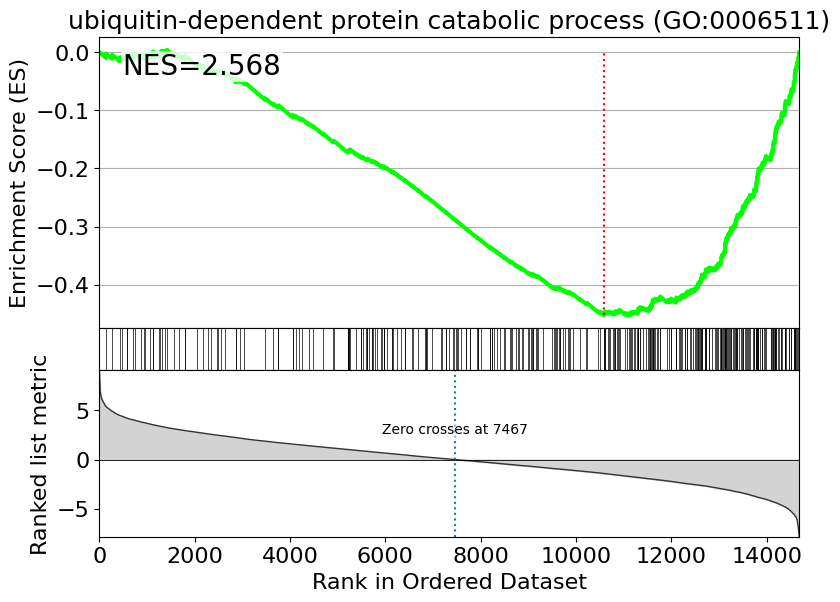

In [26]:
term = "ubiquitin-dependent protein catabolic process (GO:0006511)"

print(res.loc[term, :])

fig = blitz.plot.running_sum(signature, term, library, result=res, compact=False, center=False)
plt.show()

## Compute GSEApy runtime

Library needs to be chunked due to very high memory requirements. Chunking does not slow down the algorithm significanltly.

In [5]:
permutation_num = 1000
max_lib_size = 100
outdir='testing/prerank_report_kegg'
format='png'
seed=1
processes= 3

gpy = []

signature.columns = ["a", "b"]

sig = signature.sort_values("b", ascending=False)
sig.set_index("a")
sig = signature[~signature.index.duplicated(keep='first')]

def chopped_gsea(rnk, gene_sets, processes, permutation_num=1000, max_lib_size=50, outdir='test/prerank_report_kegg', format='png', seed=1):
    library_keys = list(gene_sets.keys())
    chunks = [library_keys[i:i+max_lib_size] for i in range(0, len(library_keys), max_lib_size)]
    results = []
    for chunk in chunks:
        tlib = {}
        for k in chunk:
            tlib[k] = gene_sets[k]
        pre_res = gseapy.prerank(rnk=rnk, gene_sets=tlib, processes=processes, permutation_num=permutation_num, outdir=outdir, format=format, seed=seed)
        results.append(pre_res.res2d)
    return pd.concat(results)

tt_gseapy = []
for p in range(1,9):
    st = time.time()
    res2 = chopped_gsea(sig, library, p, permutation_num=permutation_num, max_lib_size=50)
    et2 = time.time() - st
    tt_gseapy.append(et2)

NameError: name 'time' is not defined

In [11]:
import time

permutation_num = 2000
max_lib_size = 100
outdir='testing/prerank_report_kegg'


#signature = pd.read_csv("testing/ageing_muscle_gtex.tsv")
signature = pd.read_csv("https://github.com/MaayanLab/blitzgsea/raw/main/testing/ageing_muscle_gtex.tsv")

#library = blitz.enrichr.get_library("KEGG_2021_Human")
library = blitz.enrichr.get_library("GO_Biological_Process_2021")

st = time.time()
blitz_res = blitz.gsea(signature, library, min_size=5, max_size=4000, permutations=permutation_num, center=False, deep_accuracy=200, signature_cache=False)
print("blitz:", time.time()-st)

st = time.time()
blitz_res = blitz.gsea(signature, library, min_size=5, max_size=4000, permutations=permutation_num, center=False, deep_accuracy=200, signature_cache=True)
print("blitz cache:", time.time()-st)

#signature = pd.read_csv("testing/ageing_muscle_gtex.tsv")
signature = pd.read_csv("https://github.com/MaayanLab/blitzgsea/raw/main/testing/ageing_muscle_gtex.tsv")

signature.columns = ["i", "v"]
sig = signature.sort_values("v", ascending=False)
sig = signature[~signature.index.duplicated(keep='first')]

st = time.time()
gseapy.prerank(rnk=sig, gene_sets=library, outdir=outdir, permutation_num=permutation_num, seed=1337)
print("gseapy:", time.time()-st)

gseapy_res = pd.read_csv(outdir+"/gseapy.gene_set.prerank.report.csv", sep=",")
gseapy_res.index = gseapy_res.loc[:,"Term"]


blitz: 6.244744062423706
blitz cache: 1.9918389320373535
gseapy: 66.9427318572998


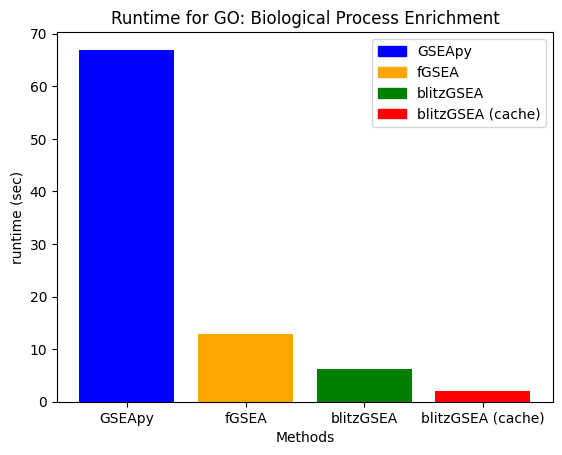

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

data = [66.94, 12.9, 6.24, 1.99]
labels = ["GSEApy", "fGSEA", "blitzGSEA", "blitzGSEA (cache)"]

colors = ['blue', 'orange', 'green', 'red']

plt.bar(range(len(data)), data, color=colors)

plt.xlabel("Methods")
plt.ylabel("runtime (sec)")
plt.title("Runtime for GO: Biological Process Enrichment")

plt.xticks(range(len(data)), labels)

legend_patches = [Patch(color=color) for color in colors]
plt.legend(legend_patches, labels)

plt.show()

Text(0, 0.5, 'GSEApy -log(p-val)')

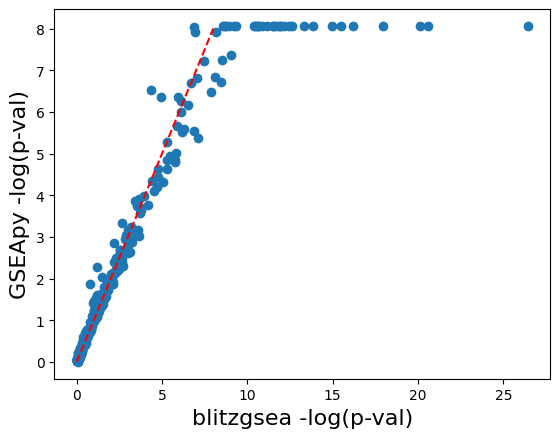

In [63]:
from matplotlib import pyplot as plt
import numpy as np

inter  = blitz_res.index.intersection(gseapy_res.index)

bp = -np.log(blitz_res.loc[inter, "pval"])
gp = -np.log(gseapy_res.loc[inter, "NOM p-val"])

max_val = np.max(gp[np.isfinite(gp)])
gp[gp == np.inf] = max_val


plt.scatter(bp, gp)

x_line = np.array([0, 8])
y_line = x_line

# Plot the line
plt.plot(x_line, y_line, 'r--')
plt.xlabel("blitzgsea -log(p-val)", fontsize=16)
plt.ylabel("GSEApy -log(p-val)", fontsize=16)


In [69]:
permutation_num = 2000
max_lib_size = 100
outdir='testing/prerank_report_kegg'

signature = pd.read_csv("testing/ageing_muscle_gtex.tsv")
library = blitz.enrichr.get_library("KEGG_2021_Human")

st = time.time()
blitz_res_1000 = blitz.gsea(signature, library, min_size=5, max_size=4000, permutations=permutation_num, center=False, deep_accuracy=200, signature_cache=False)
print("blitz:", time.time()-st)

signature = pd.read_csv("testing/ageing_muscle_gtex.tsv")
signature.columns = ["i", "v"]
sig = signature.sort_values("v", ascending=False)
sig = signature[~signature.index.duplicated(keep='first')]

st = time.time()
gseapy.prerank(rnk=sig, gene_sets=library, outdir=outdir, permutation_num=permutation_num, seed=1337)
print("gseapy:", time.time()-st)

gseapy_res_1000 = pd.read_csv(outdir+"/gseapy.gene_set.prerank.report.csv", sep=",")
gseapy_res_1000.index = gseapy_res_1000.loc[:,"Term"]

blitz: 4.558489084243774
gseapy: 16.623393058776855


Text(0, 0.5, 'GSEApy 6000 -log(p-val)')

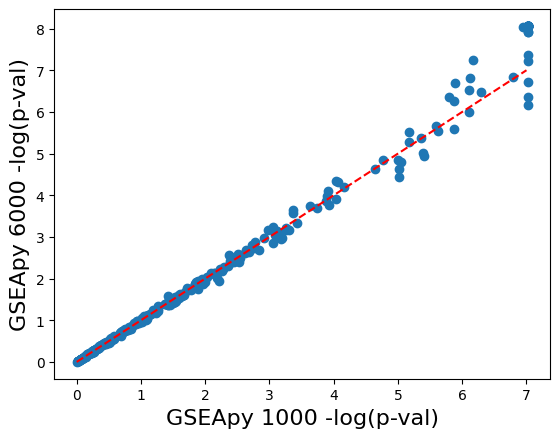

In [70]:
from matplotlib import pyplot as plt
import numpy as np

inter  = gseapy_res_1000.index.intersection(gseapy_res.index)

bp = -np.log(gseapy_res_1000.loc[inter, "NOM p-val"])
gp = -np.log(gseapy_res.loc[inter, "NOM p-val"])

max_val = np.max(gp[np.isfinite(gp)])
gp[gp == np.inf] = max_val

max_val = np.max(bp[np.isfinite(bp)])
bp[bp == np.inf] = max_val

plt.scatter(bp, gp)

x_line = np.array([0, 7])
y_line = x_line

# Plot the line
plt.plot(x_line, y_line, 'r--')
plt.xlabel("GSEApy 1000 -log(p-val)", fontsize=16)
plt.ylabel("GSEApy 6000 -log(p-val)", fontsize=16)

Text(0, 0.5, 'blitzGSEA 6000 -log(p-val)')

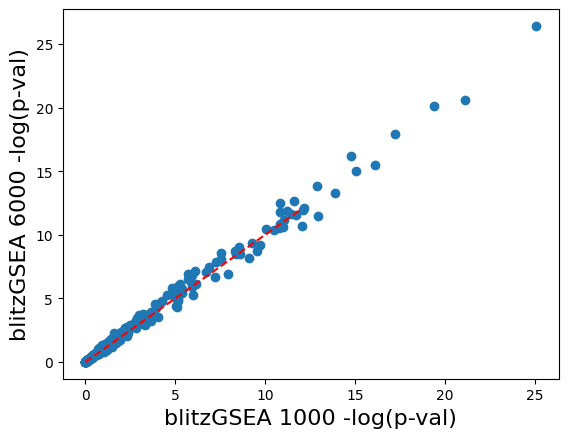

In [71]:
from matplotlib import pyplot as plt
import numpy as np

inter  = blitz_res_1000.index.intersection(gseapy_res.index)

bp = -np.log(blitz_res_1000.loc[inter, "pval"])
gp = -np.log(blitz_res.loc[inter, "pval"])

plt.scatter(bp, gp)

x_line = np.array([0, 12])
y_line = x_line

# Plot the line
plt.plot(x_line, y_line, 'r--')
plt.xlabel("blitzGSEA 1000 -log(p-val)", fontsize=16)
plt.ylabel("blitzGSEA 6000 -log(p-val)", fontsize=16)

## Plot results

Plot the results for GSEApy, fGSEA, and blitzGSEA. Speed for GSEApy and fGSEA was precomputed. fGSEA does not support multi-threading and the average runtime is plotted as a constant.

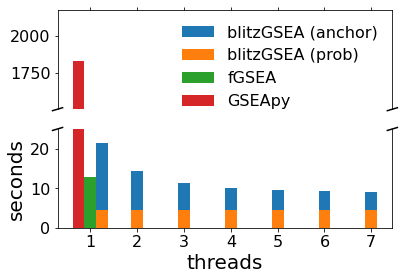

In [152]:
width = 0.5
labels = range(1,len(tt)+1)

# 12.7578 computed in R
fgsea = [12.7578]*len(tt)
x = np.array(range(1,len(tt)+1))*2
xt = np.array(x)
xt[0] = 3

tt_gseapy = tt_gseapy[0:len(tt)]

f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

rects1 = ax.bar(xt-0.25, tt, width, label='blitzGSEA (anchor)')
rects2 = ax.bar(xt-0.25, sigh, width, label='blitzGSEA (prob)')
rects3 = ax.bar(2, 12.7578, width, label='fGSEA')
rects4 = ax.bar(2-0.5, 1830.63, width, label='GSEApy')
#rects5 = ax.bar(xt+0.25, tt_gseapy, width, label='GSEApy')

rects1 = ax2.bar(xt-[0.5,0,0,0,0,0,0], tt, width, label='blitzGSEA (anchor)')
rects2 = ax2.bar(xt-[0.5,0,0,0,0,0,0], sigh, width, label='blitzGSEA (prob)')
rects3 = ax2.bar(2, 12.7578, width, label='fGSEA')
rects4 = ax2.bar(2-0.5, 200, width, label='GSEApy')

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax.tick_params(labelsize=16)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.set_ylim(min(tt_gseapy)-50, max(tt_gseapy)+50)  # outliers only
ax2.set_ylim(0, 25)  # most of the data

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax2.set_ylabel('seconds', fontsize=20)
ax2.set_xlabel('threads', fontsize=20)
plt.tick_params(labelsize=16)
ax.legend(fontsize=16, frameon=False)

plt.savefig("figures/speed_threads_fgsea.pdf", bbox_inches='tight')